<a href="https://colab.research.google.com/github/JosegSuarezb/aprendizaje-no-supervisado/blob/main/Reto2_JoseGregorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Con los datos de total_incidentes_transito.csv trabajados en clase, considere los accidentes con muertes y heridos. También considere la eliminación de accidentes 'atípicos' y eliminar posibles inconsistencias en los datos (30%).

Luego de aplicar una limpieza en los datos, considere aplicar K-means con los siguientes pasos:

Estandarización de variables (Latitud y Longitud en este caso). (10%)
Aplicar el método del codo (Realizar Gráfico). (10%)
Aplicar el puntaje de silueta (Realizar Gráfico). (10%)
(30%) ¿Cuál es el número de clústeres que determina y por qué? (utilizando el método del codo, puntaje de silueta, un gráfico del mapa).

(10%) ¿Qué diferencias observa con respecto a los resultados obtenidos en la clase? ¿Fue relevante la limpieza de los datos para abordar el problema?  

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Conexión con mi unidad en Google Drive

Mounted at /content/drive


In [ ]:
import pandas as pd # manejo de Data Frame en Python
pd.set_option('display.max_columns', 50) # Mostrar mas columnas
import numpy as np
# Librería de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# Segmentación
from sklearn.cluster import KMeans # K-means
from sklearn.metrics import silhouette_score # Score selección de clúster
from sklearn.preprocessing import StandardScaler # Estandarización

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/aprendizaje no supervisado/total_incidentes_transito.csv',
                 encoding='latin-1')
df=df.dropna()
print(df.columns)

Index(['OBJECTID', 'Shape', 'radicado', 'fecha', 'hora', 'dia', 'periodo',
       'clase', 'direccion', 'direccion_enc', 'cbml', 'tipo_geocod',
       'gravedad', 'barrio', 'comuna', 'diseno', 'dia_nombre', 'mes',
       'mes_nombre', 'x_magnamed', 'y_magnamed', 'longitud', 'latitud'],
      dtype='object')


In [ ]:
df.head()

OBJECTID                                    Shape  radicado  \
0         1   (4713091.969499999, 2248782.755800003)   1740037   
1         2        (4714910.6292, 2244088.547700003)   1756253   
2         3  (4715232.050800002, 2247305.6388000026)   1741056   
3         4        (4716026.328000001, 2254477.3071)   1759316   
4         5  (4718366.126200001, 2248621.4102999996)   1754472   

                 fecha      hora  dia  periodo      clase          direccion  \
0  2021-03-03 00:00:00  12:30:00    3     2021  Atropello    TV 39B CR 74 75   
1  2021-07-26 00:00:00  13:00:00   26     2021     Choque    CRA 48 CLL 4SUR   
2  2021-03-02 00:00:00   6:15:00    2     2021     Choque     CR 50 CL 30 28   
3  2021-08-24 00:00:00  22:40:00   24     2021       Otro  CR 65 CL 101 101A   
4  2021-07-16 00:00:00   7:40:00   16     2021       Otro     CL 56 CR 26 28   

                direccion_enc     cbml                      tipo_geocod  \
0  TV  039 B   074  000 00000  Sin inf                       Malla vial   
1   CR  048  S 004  000 00000     1422                       Malla vial   
2    CR  050   030  000 00000     1012                       Malla vial   
3    CR  065   101  000 00000      509                       Malla vial   
4    CL  056   026  000 00000      810  Malla vial aproximada: CL 56-25   

     gravedad            barrio            comuna         diseno dia_nombre  \
0      HERIDO          Laureles  Laureles Estadio  Lote o Predio  MIÉRCOLES   
1  SOLO DAÑOS     La Aguacatala        El Poblado   Interseccion  LUNES       
2      HERIDO  Perpetuo Socorro     La Candelaria   Tramo de via  MARTES      
3      HERIDO          Girardot          Castilla   Tramo de via  MARTES      
4      HERIDO          El Pinal     Villa Hermosa  Lote o Predio  VIERNES     

   mes  mes_nombre  x_magnamed  y_magnamed   longitud   latitud  
0    3  MARZO        832175.31  1182578.79 -75.593827  6.245137  
1    7  JULIO        834016.79  1177893.35 -75.577189  6.202779  
2    3  MARZO        834322.61  1181112.07 -75.574427  6.231878  
3    8  AGOSTO       835081.85  1188287.79 -75.567569  6.296749  
4    7  JULIO        837450.38  1182443.14 -75.546170  6.243911

In [ ]:
df["gravedad"].value_counts()

gravedad
HERIDO        23651
SOLO DAÑOS    16786
MUERTO          162
Name: count, dtype: int64

In [ ]:
df_filtro = df.copy() # El data frame ahora se llama df_filtro

# Crear variables por cada filtro
filtro_gravedad = df_filtro["gravedad"].isin(["HERIDO", "MUERTO"]) # Realizamos el filtro para el tipo de gravedad
filtro_atipico = (df_filtro["longitud"]<-75.65) & (df_filtro["latitud"]>6.3) # "atípicos"
filtro_comuna = df_filtro["comuna"].isin( [ 'In', 'Sin inf', ' ', 'SN', 'Sin Inf' ] ) # Definimos el filtro para comuna #filtro_comuna = df_filtro[~df_filtro['comuna'].isin(['IN', 'Sin Inf'])]
df_filtro = df_filtro.loc[filtro_gravedad & ~filtro_atipico & ~filtro_comuna, :] # ahora aplicamos & con todos los filtros

# Al final obtenemos que se cumplan todas las condiciones de los filtros
df_filtro


OBJECTID                                    Shape  radicado  \
0             1   (4713091.969499999, 2248782.755800003)   1740037   
2             3  (4715232.050800002, 2247305.6388000026)   1741056   
3             4        (4716026.328000001, 2254477.3071)   1759316   
4             5  (4718366.126200001, 2248621.4102999996)   1754472   
6             7       (4710810.5665, 2252371.4015999995)   1751782   
...         ...                                      ...       ...   
40594     40595   (4714981.318700001, 2254779.946300002)   1743080   
40595     40596   (4712668.976900001, 2249885.013600003)   1774149   
40596     40597   (4718239.037600001, 2251226.429399999)   1758468   
40597     40598  (4716560.627900001, 2248431.7728000022)   1742119   
40598     40599       (4717071.7745, 2251897.4152999986)   1763007   

                     fecha      hora  dia  periodo           clase  \
0      2021-03-03 00:00:00  12:30:00    3     2021       Atropello   
2      2021-03-02 00:00:00   6:15:00    2     2021          Choque   
3      2021-08-24 00:00:00  22:40:00   24     2021            Otro   
4      2021-07-16 00:00:00   7:40:00   16     2021            Otro   
6      2021-06-21 00:00:00  22:30:00   21     2021          Choque   
...                    ...       ...  ...      ...             ...   
40594  2021-03-25 00:00:00  12:30:00   25     2021          Choque   
40595  2021-12-16 00:00:00   4:20:00   16     2021          Choque   
40596  2021-08-13 00:00:00   5:30:00   13     2021       Atropello   
40597  2021-03-20 00:00:00  13:20:00   20     2021     Volcamiento   
40598  2021-09-21 00:00:00  13:30:00   21     2021  Caida Ocupante   

                    direccion               direccion_enc     cbml  \
0             TV 39B CR 74 75  TV  039 B   074  000 00000  Sin inf   
2              CR 50 CL 30 28    CR  050   030  000 00000     1012   
3           CR 65 CL 101 101A    CR  065   101  000 00000      509   
4              CL 56 CR 26 28    CL  056   026  000 00000      810   
6               CL 63 CR 104C  CL  063   104 C  000 00000     6098   
...                       ...                         ...      ...   
40594            CR 76 CL 101    CR  076   101  000 00000      604   
40595          CLL 45GG 79 48  CL  045 GG  079  000 00000     1112   
40596             CR 36 CL 73    CR  036   073  000 00000      308   
40597        CLL 46 CRA 40 43    CL  046   040  000 00000     1015   
40598  CARRERA 49 CALLE 80 81    CR  049   080  000 00000      410   

                           tipo_geocod gravedad                      barrio  \
0                           Malla vial   HERIDO                    Laureles   
2                           Malla vial   HERIDO            Perpetuo Socorro   
3                           Malla vial   HERIDO                    Girardot   
4      Malla vial aproximada: CL 56-25   HERIDO                    El Pinal   
6                           Malla vial   HERIDO  Área de Expansión Pajarito   
...                                ...      ...                         ...   
40594                       Malla vial   HERIDO                    Pedregal   
40595                       Malla vial   HERIDO                El Velódromo   
40596  Malla vial aproximada: CR 36-72   HERIDO           Manrique Oriental   
40597                       Malla vial   HERIDO               Bomboná No. 1   
40598                       Malla vial   HERIDO          Campo Valdés No. 1   

                               comuna         diseno dia_nombre  mes  \
0                    Laureles Estadio  Lote o Predio  MIÉRCOLES    3   
2                       La Candelaria   Tramo de via  MARTES       3   
3                            Castilla   Tramo de via  MARTES       8   
4                       Villa Hermosa  Lote o Predio  VIERNES      7   
6      Corregimiento de San Cristóbal  Lote o Predio  LUNES        6   
...                               ...            ...        ...  ...   
40594                 Doce de O

In [ ]:
df_filtro["comuna"]

0                      Laureles Estadio
2                         La Candelaria
3                              Castilla
4                         Villa Hermosa
6        Corregimiento de San Cristóbal
                      ...              
40594                   Doce de Octubre
40595                  Laureles Estadio
40596                          Manrique
40597                     La Candelaria
40598                          Aranjuez
Name: comuna, Length: 20313, dtype: object

In [ ]:
df_filtro["gravedad"].value_counts()

gravedad
HERIDO    20177
MUERTO      136
Name: count, dtype: int64

MAPA COMUNAS

In [ ]:
fig = px.scatter_mapbox(df_filtro, lat="latitud", lon="longitud", color="comuna")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ESTANDARIZACION DE VARIABLES

In [ ]:
df_var= df_filtro[["longitud","latitud"]] # Seleccionamos las columnas
scaler = StandardScaler() #Estandariza las variables
scaled_features = scaler.fit_transform(df_var)
scaled_features # Transforma a numpy, una matriz

array([[-0.93783608, -0.39006476],
       [ 0.05308508, -0.87332894],
       [ 0.4034235 ,  1.49110038],
       ...,
       [ 1.43195659,  0.42345209],
       [ 0.66365347, -0.50012019],
       [ 0.89174826,  0.64267983]])

MAPA CENTROS

In [ ]:
centros =  df_filtro.groupby("cluster")[["latitud","longitud"] ].mean() # obtener el centros

In [ ]:
#Mapa Centros

fig = px.scatter_mapbox(df_filtro, lat="latitud", lon="longitud", color="cluster")
fig.add_scattermapbox(lat=centros.reset_index()['latitud'], lon=centros.reset_index()['longitud'],marker_size=10,marker_color="black")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Metodo del codo

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

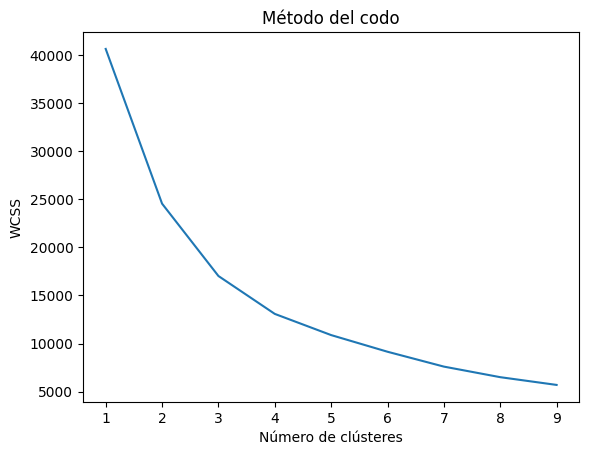

In [ ]:
wcss = [] # valores de WCSS
lista_num_cluster = range(1, 10) # Número de clústeres
# Por cada número de clústeres
for i in lista_num_cluster:
    kmeans = KMeans(n_clusters=i, random_state=123) # Definir el modelo
    kmeans.fit(scaled_features) # entrenar el modelo
    value_wcss= kmeans.inertia_ # extraer el WCSS del modelo
    wcss.append(value_wcss) # Añadir a la lista
# Gráficar resultados
plt.plot(lista_num_cluster, wcss)
plt.title('Método del codo')
plt.xlabel('Número de clústeres')
plt.ylabel('WCSS')
plt.show()

Puntaje de silueta

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will 

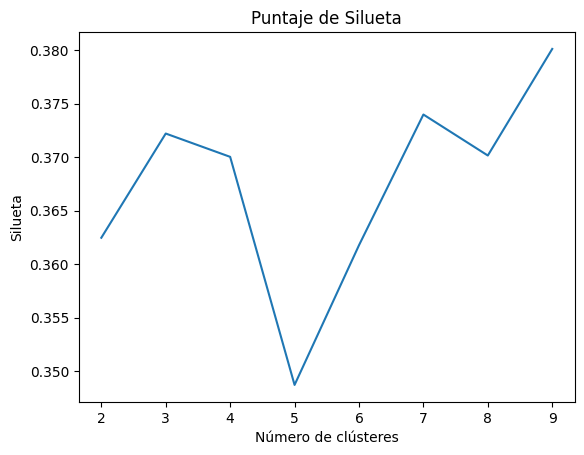

In [ ]:
silueta = [] # valores de puntuación de silueta
lista_num_cluster = range(2, 10) # Número de clústeres
# Por cada número de clústeres
for i in lista_num_cluster:
    kmeans = KMeans(n_clusters=i, random_state=123) # Definir el modelo
    kmeans.fit(scaled_features) # entrenar el modelo
    score_slueta= silhouette_score(scaled_features,  kmeans.labels_)  # Calcular el score
    silueta.append(score_slueta) # Añadir a la lista
# Gráficar resultados
plt.plot(lista_num_cluster, silueta)
plt.title('Puntaje de Silueta')
plt.xlabel('Número de clústeres')
plt.ylabel('Silueta')
plt.show()

Algoritmo K-means y mapa

In [ ]:
kmeans = KMeans(n_clusters=7,  random_state=123) # Definir el algoritmo
kmeans.fit(scaled_features)  # Entrenar el modelo
df_filtro["cluster"] = kmeans.labels_ # Obtener las etiquetas
df_filtro["cluster"] = df_filtro["cluster"].astype(str) # Convertir a categoria

fig = px.scatter_mapbox(df_filtro, lat="latitud", lon="longitud", color="cluster")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
df_filtro["cluster"].value_counts(normalize = True)

cluster
1    0.241274
2    0.161571
3    0.161473
4    0.161374
0    0.153498
6    0.113031
5    0.007778
Name: proportion, dtype: float64

**¿Cuál es el número de clústeres que determina y por qué? (utilizando el método del codo, puntaje de silueta, un gráfico del mapa).**

De acuerdo con el metodo del codo el recomendable seria 3 pero teniendo en cuenta la realizacion del grafico del mapa con 3 clusters se ve aun incongruencias con respecto al corregimiento al sur de la ciudad por lo que con el puntaje silueta nos recomienda que el numero correcto de clusters es 7 y luego de realizar el grafico del mapa con 7 clusters si muestra una buena distribucion de los clusters haciendo que el puntaje de silueta sea el que mejor recomiendacion nos dio.

**¿Qué diferencias observa con respecto a los resultados obtenidos en la clase? ¿Fue relevante la limpieza de los datos para abordar el problema?**

Teniendo en cuenta la realizado en clase con los resultados del reto 2 hubo una mejor diferencia con respecto a la grafica del mapa con los clusters ya que despues de haber realizado el filtro se logro quitar muchos datos atipicos haciendo que la limpieza de datos fue demasiado relevante.